In [60]:
import xarray as xr
import contextily as cx
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io import img_tiles as cimgt
from matplotlib.patches import Patch

from shared import *
from make_slr_cari import main, get_enso_poly

%matplotlib inline
%pdb off

print (os.getenv('CONDA_PROMPT_MODIFIER'), datetime.now())
# Rule: SetNull(CoNED < MLLW | (CoNED > ZT & ElNino > ZT)

Automatic pdb calling has been turned OFF
(SL)  2024-09-04 16:27:06.733203


In [61]:
region  = 'Central' 
use_s2  = False
use_vlm = True
path_wd = Path(os.getenv('dataroot')) / 'Sea_Level' / 'SFEI'
print ('Region:', region)

Region: Central


In [62]:
BObj = CARIRegion(region, path_wd, use_s2)
gdf_rocky_coned = BObj.get_cari('rocky')
gdf_rocky_wgs = gdf_rocky_coned.to_crs(4326)

s2_ext = '_s2' if use_s2 else ''
vlm_ext = '_vlm' if use_vlm else ''
path_log = BObj.path_wd / f'log_{BObj.region}_rocky_pct{s2_ext}{vlm_ext}.txt'

In [63]:
basemap_d = cimgt.GoogleTiles(url='https://server.arcgisonline.com/ArcGIS/rest/services/Elevation/World_Hillshade_Dark/MapServer/tile/{z}/{y}/{x}.jpg')
basemap   = cimgt.GoogleTiles(url='https://server.arcgisonline.com/arcgis/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}.jpg')

cxbasemap   = cx.providers.Esri.WorldImagery
cxbasemap_d = cx.providers.CartoDB.DarkMatter
cxbasemap_t = cx.providers.USGS.USTopo

projp     = ccrs.PlateCarree()

dct_proju = {'Central': ccrs.UTM(10), 'North': ccrs.UTM(10), 'South': ccrs.UTM(11)}
proju     = dct_proju[region]

TFS = 20 # title
XFS = YFS = 16 # x/y axis
GFS = 14 # deg marks
CFS = 18 # colorbar labels
pt_parms = dict(verticalalignment='top', fontsize=20, color='w',
                bbox=dict(boxstyle='square,pad=0.05', facecolor='black'))

## setup plot parms and patch label outines
sty_cari = dict(facecolor='none', edgecolor='deeppink') 
sty_coned = dict(facecolor='none', edgecolor='red', linestyle='--')
sty_enso = dict(facecolor='none', edgecolor='black') 

rect_coned = Patch(label='CoNED Tile', **sty_coned)
rect_cari = Patch(label='CARI Polygon', **sty_cari)
rect_enso = Patch(label='CARI Polygon', **sty_enso)

point      = plt.Line2D([0], [0], marker='o', color='k', label='Beach', linestyle='none')
point_lost = plt.Line2D([0], [0], marker='o', color='k', label='Lost Beach', linestyle='none')

In [64]:
def buffer_poly(gser, buffx, buffy=None):
    buffy = buffx if buffy is None else buffy
    
    w, s, e, n = gser.total_bounds
    return w-buffx, s-buffy, e+buffx, n+buffy

# Check Results

## Single Test Run

In [56]:
scen_test0 = 'High2100'
# scen_test = scen_test0.replace('_rsl', '')
da_dem_test, da_mllw0_test, da_mllw_slr_test, df_slr_test, poly_test = main(region, 'rocky', scen=scen_test0, use_s2=use_s2, use_vlm=use_vlm, test=True)


INFO:   main:132    [Sep 04, 13:53:17] 258 rocky polygons within CentCA_south_Topobathy_CoNED_1m_B3
CRITICAL:   main:171    [Sep 04, 13:53:47] CentCA_south_Topobathy_CoNED_1m_B3, polyix=94 cari id=8906:
CRITICAL:   compare_elevations_poly:85     [Sep 04, 13:53:52] 	98.020% ABOVE MLLW today; 14.131 in High2100. 	Lost: 83.888% 
CRITICAL:   compare_elevations_poly:85     [Sep 04, 13:53:57] 	85.509% ABOVE MAH today; 97.750 in High2100. 	Gained: 12.241% 
CRITICAL:   compare_elevations_poly:85     [Sep 04, 13:54:03] 	86.769% ABOVE MAH_ENSO today; 97.930 in High2100. 	Gained: 11.161% 


In [7]:
TestObj = SetupProj(region, 'rocky', scen_test0, BObj.path_wd, use_s2)

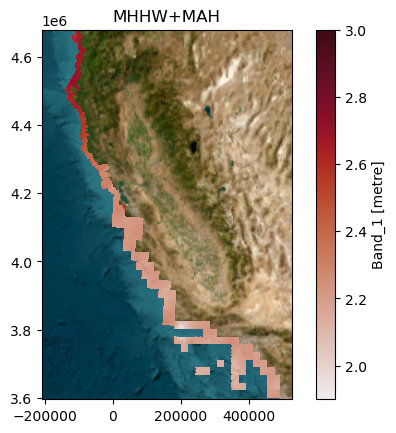

In [8]:
path_mah = BObj.path_wd / 'JPL_Share' / 'MHHW_Plus_MAH_NAVD88m_IDW.tif'
da_mah = xrr.open_rasterio(path_mah)
da_mah_re = da_mah.sel(band=1).rio.reproject(TestObj.epsg)
da_mah_re = da_mah_re.where(da_mah_re < 1e20, np.nan)
da_mah_re.rio.write_nodata(da_mah_re.rio.nodata, encoded=True, inplace=True)

qm = da_mah_re.plot(vmin=1.9, vmax=3, cmap='cmo.amp')
cx.add_basemap(ax=qm.axes, crs=da_mah_re.rio.crs, source=cxbasemap, attribution=False, zoom=5)
qm.axes.set_title('MHHW+MAH')
qm.axes.set_ylabel('')
qm.axes.set_xlabel('');

# Check 0 gdfs 
- Rocky North, no polygons found within a tile
- The issue is likely that no polygons in the tile hit the ENSO dem

In [27]:
from shapely.geometry import box
BObj_north = CARIRegion('North', path_wd, use_s2)
gdf_rocky_coned = BObj_north.get_cari('rocky')
tile = 'Northern_California_CoNED_TBDEM_1m_006_005.tif' # weird poly in the water, no ENSO overlap
# tile = 'Northern_California_CoNED_TBDEM_1m_075_016.tif' # no rioxarray

In [28]:
da_dem_tile = xrr.open_rasterio(BObj_north.path_ca_dems / tile).sel(band=1) 
da_dem_tile = da_dem_tile.where(da_dem_tile>-1e20)
da_dem_tile.rio.write_nodata(da_dem_tile.rio.nodata, encoded=True, inplace=True)

coned_bounds = da_dem_tile.rio.bounds()
gser_bounds = gpd.GeoSeries(box(*coned_bounds), crs=da_dem_tile.rio.crs)

wc, sc, ec, nc = coned_bounds
gdf_rocky_tile = gdf_rocky_coned.cx[wc:ec, sc:nc]
print (f'{gdf_rocky_tile.shape[0]} polygons in CoNED tile')

# cut the dem tile
da_dem_tile_poly = da_dem_tile.rio.clip(gdf_rocky_tile.geometry, all_touched=True)

130 polygons in CoNED tile


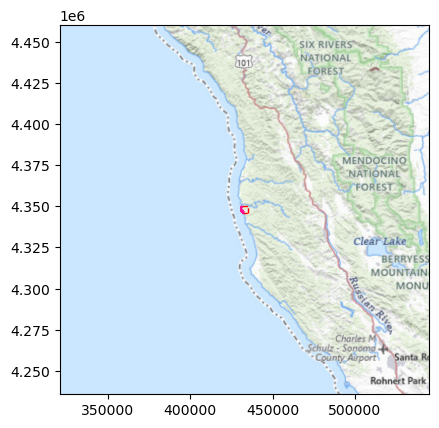

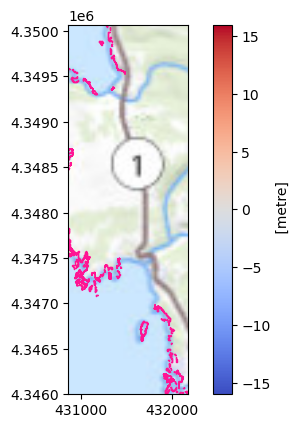

In [33]:
# plot an overview of the CONeD tile with the CARI polygon(s)
ax = gser_bounds.buffer(1e5).plot(alpha=0)
gser_bounds.plot(ax=ax, **sty_coned)
gdf_rocky_tile.plot(ax=ax, **sty_cari)
cx.add_basemap(ax=ax, crs=da_dem_tile.rio.crs, source=cxbasemap_t, attribution=False, zoom=8)

## plot a closeup
ax = gser_bounds.buffer(10).plot(alpha=0)
da_dem_tile_poly.plot(ax=ax, cmap='coolwarm', norm=mpl.colors.TwoSlopeNorm(0))
gser_bounds.plot(ax=ax, **sty_coned)
gdf_rocky_tile.plot(ax=ax, **sty_cari)
cx.add_basemap(ax=ax, crs=da_dem_tile.rio.crs, source=cxbasemap_t, attribution=False, zoom=16)
ax.set_title(''); ax.set_ylabel(''); ax.set_xlabel('');

In [34]:
# try and get the enso dem file that contains these polygons
gdf_enso_map = get_enso_map(BObj_north.path_enso_dems, BObj_north.epsg) # enso dem path and its bounds
gdf_enso_polys = gdf_enso_map.sjoin(gdf_rocky_tile, predicate='intersects')
print (f'ENSO DEM *intersects* {gdf_enso_polys.shape[0]} polys (of coned tile {tile})')

ENSO DEM *intersects* 134 polys (of coned tile Northern_California_CoNED_TBDEM_1m_075_016.tif)


In [42]:
# plot north enso coverage in this tile ... might be empty
gdf_enso_tile = gdf_enso_map.sjoin(gpd.GeoDataFrame(gser_bounds, columns=['geometry']).to_crs(gdf_enso_map.crs), 
                                   predicate='intersects') # crs are actually same before transform
if gdf_enso_tile.empty:
    print ('ENSO DEM intersects 0 CoNED tiles')
    print ('Buffering around the polygons to visualize')
    gdf_rocky_tile_close = gdf_rocky_tile.buffer(2e4)
else:
    print ('This shouldnt happen...')
    gdf_rocky_tile_close = gdf_enso_tile

This shouldnt happen...


The actual polygon is in the center (and probably very tiny!


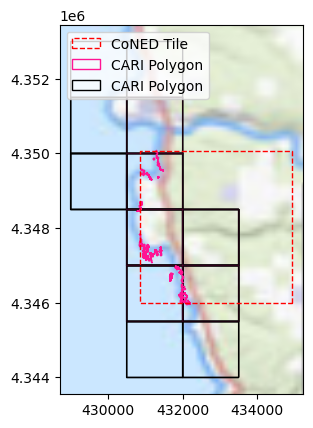

In [64]:
# zoom in around the polygon
print ('The actual polygon is in the center (and probably very tiny!')
gdf_enso_close = gdf_enso_map.sjoin(gpd.GeoDataFrame(gdf_rocky_tile_close, columns=['geometry']), predicate='intersects')

ax = gdf_rocky_tile_close.plot(alpha=0)
gdf_enso_close.plot(ax=ax, facecolor='none', edgecolor='k')
gdf_rocky_tile.plot(ax=ax, **sty_cari)
gdf_rocky_tile_close.plot(ax=ax, **sty_cari, alpha=0.1)
## plot the CONED tile as well
gser_bounds.plot(ax=ax, **sty_coned)
cx.add_basemap(ax=ax, crs=BObj_north.epsg, source=cxbasemap_t, attribution=False, zoom=10)
ax.legend(handles=[rect_coned, rect_cari, rect_enso], loc='upper left');

# No ENSO Data in Bounds
- there is no polygon in the ENSO after interpolating it to the DEM because the DEM only slightly touched the edge; this is now accounted for

In [47]:
from shapely.geometry import box
BObj_north = CARIRegion('North', path_wd, use_s2)
gdf_rocky_coned = BObj_north.get_cari('rocky')
tile = 'Northern_California_CoNED_TBDEM_1m_075_016.tif' # should grab these from log
gdf_enso_map = get_enso_map(BObj_north.path_enso_dems, BObj_north.epsg) # enso dem path and its bounds

In [54]:
poly_ix = 6431
gdf_rocky_poly = gdf_rocky_coned.loc[[poly_ix]] # i checked this is correct against actual polygon geom passed to get_enso_poly

# get the path
gdf_enso_map_poly = gdf_enso_map[gdf_enso_map.intersects(gdf_rocky_poly.geometry.item())]

,path,geometry
148,/scratch/tws_grace/data/Sea_Level/SFEI/dems/We...,"POLYGON ((432000.029 4346999.922, 432000.031 4..."


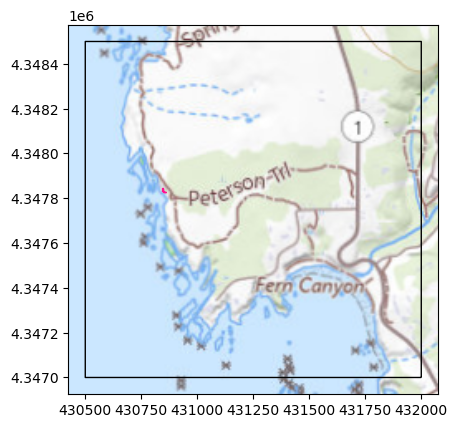

In [59]:
ax = gdf_rocky_poly.plot(**sty_cari)
gdf_enso_map_poly.plot(ax=ax, **sty_enso)
cx.add_basemap(ax=ax, crs=BObj_north.epsg, source=cxbasemap_t, attribution=False, zoom=14)

In [97]:
# get the coned DEM
da_dem = xrr.open_rasterio(BObj_north.path_ca_dems / tile).sel(band=1)
da_dem = da_dem.where(da_dem>-3e4)
da_dem.rio.write_nodata(da_dem.rio.nodata, encoded=True, inplace=True)
gser_bounds  = gpd.GeoSeries(box(*da_dem.rio.bounds()), crs=BObj_north.epsg)
da_dem1 = da_dem.rio.clip([gdf_rocky_poly.geometry.item()], BObj_north.epsg, all_touched=True);
gser_bounds1 = gpd.GeoSeries(box(*da_dem1.rio.bounds()), crs=BObj_north.epsg)

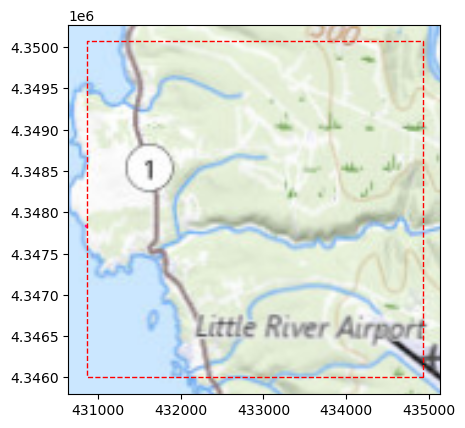

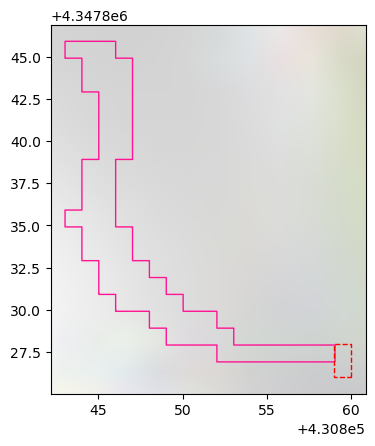

In [100]:
## plot the polygon and the bounds of the DEM
ax = gdf_rocky_poly.plot(**sty_cari)
gser_bounds.plot(ax=ax, **sty_coned)
cx.add_basemap(ax=ax, crs=BObj_north.epsg, source=cxbasemap_t, attribution=False, zoom=12)

## plot a close up of the polygon and the bounds DEM after clipping to it
ax = gdf_rocky_poly.plot(**sty_cari)
gser_bounds1.plot(ax=ax, **sty_coned)
cx.add_basemap(ax=ax, crs=BObj_north.epsg, source=cxbasemap_t, attribution=False, zoom=16)

# Check 2 ENSO Tiles

In [15]:
from shapely.geometry import box
BObj_north = CARIRegion('North', path_wd, use_s2)
gdf_rocky_coned = BObj_north.get_cari('rocky')
tile = 'Northern_California_CoNED_TBDEM_1m_050_007.tif' # from log

1 polygons in CoNED tile


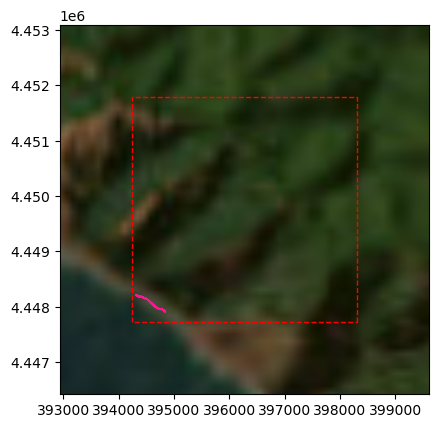

In [19]:
# plot an overview of the tile with the CARI polygon(s)
da_dem_tile = xrr.open_rasterio(BObj_north.path_ca_dems / tile).sel(band=1) 
da_dem_tile = da_dem_tile.where(da_dem_tile>-1e20)
da_dem_tile.rio.write_nodata(da_dem_tile.rio.nodata, encoded=True, inplace=True)

coned_bounds = da_dem_tile.rio.bounds()
gser_bounds = gpd.GeoSeries(box(*coned_bounds), crs=da_dem_tile.rio.crs)

wc, sc, ec, nc = coned_bounds
gdf_rocky_tile = gdf_rocky_coned.cx[wc:ec, sc:nc]
print (f'{gdf_rocky_tile.shape[0]} polygons in CoNED tile')

# plot all
ax = gser_bounds.buffer(1e3).plot(alpha=0)
gser_bounds.plot(ax=ax, **sty_coned)
gdf_rocky_tile.plot(ax=ax, **sty_cari)

cx.add_basemap(ax=ax, crs=da_dem_tile.rio.crs, source=cxbasemap, attribution=False, zoom=10)

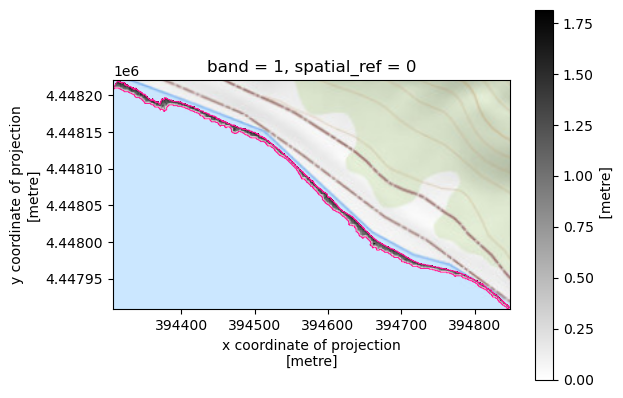

In [20]:
## close up on the tile and polygon
da_dem_poly = da_dem_tile.rio.clip(gdf_rocky_tile.geometry.to_numpy(), crs=gdf_rocky_tile.crs, all_touched=True)

qm = da_dem_poly.plot(cmap='binary')
ax = qm.axes
gdf_rocky_tile.plot(ax=ax, **sty_cari, linewidth=0.7)
cx.add_basemap(ax=ax, crs=da_dem_tile.rio.crs, source=cxbasemap_t, attribution=False, zoom=16);

In [21]:
# get the enso dem file that contains this polygon
gdf_enso_map = get_enso_map(BObj_north.path_enso_dems, BObj_north.epsg) # enso dem path and its bounds
print ('ENSO contains poly?', gdf_enso_map.contains(gdf_rocky_tile.geometry.item()).any())
gdf_enso_poly = gdf_enso_map[gdf_enso_map.intersects(gdf_rocky_tile.geometry.item())]
print ('ENSO *intersects* poly?', not gdf_enso_poly.empty)

ENSO contains poly? False
ENSO *intersects* poly? True


In [22]:
poly1 = gdf_rocky_tile.geometry.item()
da_enso_m = get_enso_poly(gdf_enso_map, da_dem_tile, poly1)

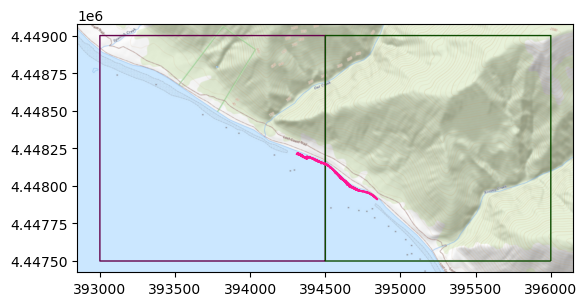

In [23]:
## overview; outline is the two tiles 
ax = gdf_enso_poly.plot(cmap='cmc.bam', facecolor='none')#, legend=True)
gdf_rocky_tile.plot(ax=ax, **sty_cari)
cx.add_basemap(ax=ax, crs=gdf_rocky_tile.crs, source=cxbasemap_t, attribution=False, zoom=16);

NameError: name 'da_m' is not defined

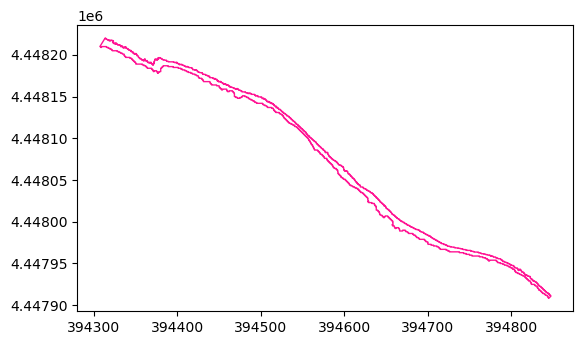

In [24]:
## close up on the tile and polygon
ax = gdf_rocky_tile.plot( **sty_cari)
da_m.plot(ax=ax)
cx.add_basemap(ax=ax, crs=gdf_rocky_tile.crs, source=cxbasemap_t, attribution=False, zoom=16);